# Conformal Prediction for Regression

In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,KFold
from sklearn.base import clone

from mapie.regression import MapieRegressor
from mapie.metrics import regression_mean_width_score
from mapie.metrics import regression_coverage_score_v2 as regression_coverage_score

# Vector Graphics
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps


<div align="justify">

We now discuss Conformal prediction applied to regression tasks. We recommend reading the Chapter on [Conformal Classification](../chapter-conformel_classification/conformel_classification) as it covers the general idea. Regression is done through inductive conformal prediction which can be briefly described in four steps:

1. Divide the $x_1, \dots, x_n$ data points into $x_1, \dots, x_k$ training points and $x_{k+1}, \dots, x_{k+l-1}, x_{n}$ validation points such that $n = k + l$.
2. Train a arbitrary machine learning model on the  training set.
3. Calculate the non-conformity scores based on the calibration set.
4. Based on these value create a prediction interval for each new observation $x_{n+1}$.

The non-conformity function $f$ expresses the  ''weirdness'' of a label $y$ given the features $x$.
For the non-conformity function $f$ we use the *absolute residual score* the most commonly used function in regression:

$$
    f_h(x,y) = | y - h(x) |
$$

where $h$ is the underlying machine learning model we use.

</div>

In [2]:
# paramters that can be tweaked
random_state = 42
np.random.seed(random_state)
epsilon = 0.05
mu, sigma, n_samples, noise = 0, 2, 500, .5

# Used for plotting the target function
X_general = np.arange(mu - 3*sigma, mu + 3*sigma, step = sigma/20)
norm_quantile = sps.norm.ppf(1 - epsilon) 

def evaluate_interval(y_true, intervals):
    y_interval_low = intervals[:,0]
    y_interval_high = intervals[:,1]
    print("RCS: ", *regression_coverage_score(y_true,np.expand_dims(intervals,axis=2)))
    print("RMWS: ", regression_mean_width_score(y_interval_low,y_interval_high))

def are_both_intervals_equal(interval1,interval2):
    print("Are both inervals equal?")
    if np.all(interval1 == interval2):
        print("Yes, both are equal!")
    else:
        print("No, both are not equal!")


def target_function(X):
    return X * np.sin(X)**2

def create_regression_data(mu,sigma, n_samples, noise):
    X_train = np.random.normal(mu,sigma,n_samples).reshape(-1,1)
    X_test = np.arange(mu - 3*sigma, mu + 3*sigma, sigma/10).reshape(-1,1)
    
    y_train = target_function(X_train) + np.random.normal(0,
                                                          noise,
                                                          X_train.shape[0])[:,None]
    y_test = target_function(X_test) + np.random.normal(0,
                                                        noise,
                                                        X_test.shape[0])[:,None]

    return (
        X_train,
        X_test,
        y_train.ravel(),
        y_test.ravel()
    )
    
def get_coverage(true_ground, interval):
    coverage = 0
    for i, inter in enumerate(interval):
        current_value = true_ground[i]
        coverage += inter[0] <= current_value <= inter[1]
    coverage = coverage / len(true_ground)
    return coverage

def plot_data(
    X_train,
    X_test,
    y_train,
    y_test,
    y_pred=None,              
    y_pred_interval=None,
    method=None):
    
    fig, ax = plt.subplots()
    fig.set_size_inches(w=12,h=5)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    # plot the true relationship with confidence intervals
    ax.plot(
        X_general, target_function(X_general), color="gray", ls="-", label="ground_truth"
    )
    ax.plot(X_general, target_function(X_general) - norm_quantile * noise, color="gray", ls="--", label="95% confidence interval of ground_truth")
    ax.plot(X_general, target_function(X_general) + norm_quantile * noise, color="gray", ls="--")

    if y_pred is not None and y_pred_interval is not None:
        # plot the prediction plus the interval
        ax.scatter(X_test,y_pred,color="aqua", label="prediction")
        ax.fill_between(X_test.ravel(), y_pred_interval[:,0].ravel(), y_pred_interval[:,1].ravel(), alpha=.4, label="prediction_coverage")

    # plot the data points
    ax.scatter(X_train, y_train, color="green", label="train data", alpha=.3)
    ax.scatter(X_test, y_test, color="red", label="test data")

    # set title
    if method != None:
        ax.set_title(f"Visualization of \"{method}\" having RCS = {round(regression_coverage_score(y_test,np.expand_dims(y_pred_interval,axis=2))[0],2)}")
    else:
        ax.set_title(f"Visualization of data")
    ax.legend(loc="upper center")
    
    plt.show()

In [3]:

##### Jupyter Book auxiliary########
from myst_nb import glue
glue("mu",mu, display=False) # makes the vairble mu abailable in markdown cell with {glue:}`mu`
glue("sigma",sigma, display=False)
glue("noise", noise, display=False)
###################################


<div align="justify">

There are different ways of calculating the non-conformity scores and prediction intervals namely [Split](content:split), [Jackknife](content:jackknife), [Jackknife+](content:jackknife_plus) and [CV+](content:cv_plus) which we will present.
For the conformal regression implementation we will again use the [MAPIE](https://mapie.readthedocs.io/en/stable/) package. 
Barebone implementations are available at the end of each chapter. \
We apply these methods to synthetic data, with features X being drawn from a Gaussian distribution with parameters $\mu = $ {glue:}`mu`, $\sigma=$ {glue:}`sigma`.
The relationship between the X values and target y is described by the function $x \mapsto x\sin(x)^2$.
Noise was added to y drawn from a Gaussian distribution with $\mu=0$ and $\sigma=${glue:}`noise`.

</div>

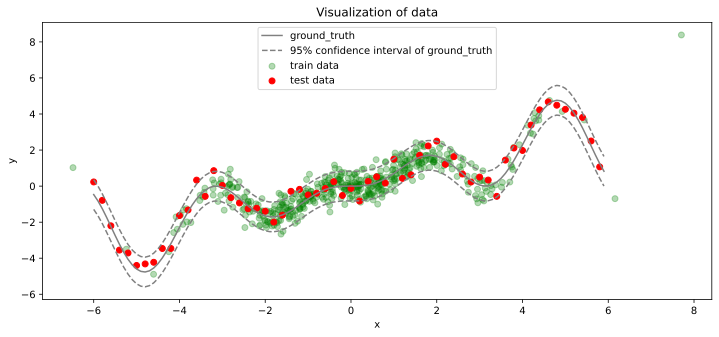

In [4]:
X_train,X_test,y_train,y_test = create_regression_data(mu,
                                                       sigma,
                                                       n_samples,
                                                       noise)
plot_data(X_train,X_test,y_train,y_test)

To compare the presented methods we compute the *Regression coverage score (RCS)* 

$$

\text{RCS} = \frac{1}{n} \sum_{i=1}^{n} \mathbf{1}(\hat y^{\text{low}}_{i} \leq y_{i} \leq \hat y^{\text{up}}_{i})

$$ 

and *Regression Mean Width Score (RMWS)* 

$$

\text{RMWS} = \frac{1}{n} \sum_{i=1}^{n} (\hat y^{\text{up}}_{i} - \hat y^{\text{low}}_{i})

$$


(content:split)=
## Split Method

<div align="justify">

This method uses  only a single train/validation split to compute the non-conformity scores and is the most simplest approach.
It can be described by the following steps:

1. Split the $n$  data points into $k$ training and $l$ validation points such that $n=k+l$ and fit a model $\hat{h}$ on the training data.
2. Given $i = l, l+1, \dots, l+k-1, n$ validation points calculate the non-conformity scores $\alpha_i = f_{\hat{h}}(y_i, x_i)$.
3. Calculate the Quantile $ q_{split} = \lceil (1-\epsilon)*(l+1)\rceil \text{-Quantile of the sequence }(\alpha_{l}, \, \alpha_{l+1}, \ldots , \alpha_{n})$ for a predefined significance level $\epsilon$.
4. Build the prediction interval $Y_\epsilon$ for a new data point $x_{n+1}$:

$$
    Y_\epsilon = [\hat{h}(x_{n+1} - q_{split} \ , \ \hat h(x_{n+1})  + q_{split})].
$$

Given the above data, we firstly split the training into proper training and validation data.

</div>

In [5]:
X_train_prefit,X_val,y_train_prefit,y_val = train_test_split(X_train,y_train,
                                               train_size=0.8,
                                               random_state=random_state)

<div align="justify">

In the next step we fit an arbitrary machine learning algorithm to the training data.
Through out the page we will use the [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).

</div>

In [6]:
base_model = RandomForestRegressor(n_estimators=100,
                                   random_state=random_state)

base_model.fit(X_train_prefit, y_train_prefit)

RandomForestRegressor(random_state=42)

<div align="justify">

To apply the Split method with [MAPIE](https://mapie.readthedocs.io/en/stable/), we need to set `method` and `cv` (see [here](https://mapie.readthedocs.io/en/stable/generated/mapie.regression.MapieRegressor.html#mapie.regression.MapieRegressor) for detailed description of the parameters).
- `method="base"` tells MAPIE, when constructing the prediction interval to apply the non-conformity function to the calibration dataset.\
- `cv="prefit"` indicates that the `estimator` has already been fitted to the data.
</div>

In [7]:
prefit_model = MapieRegressor(
    estimator=base_model,
    method="base",
    cv="prefit",
    random_state=random_state,
    n_jobs=-1
)
prefit_model.fit(X_val, y_val)
y_pred_split, y_interval_split = prefit_model.predict(X_test,
                                             alpha=epsilon)
y_interval_split = y_interval_split.reshape(-1, 2) # This is can only be done because we use a single alpha/epsilon value

evaluate_interval(y_test,y_interval_split)

RCS:  0.95
RMWS:  2.557984632366192


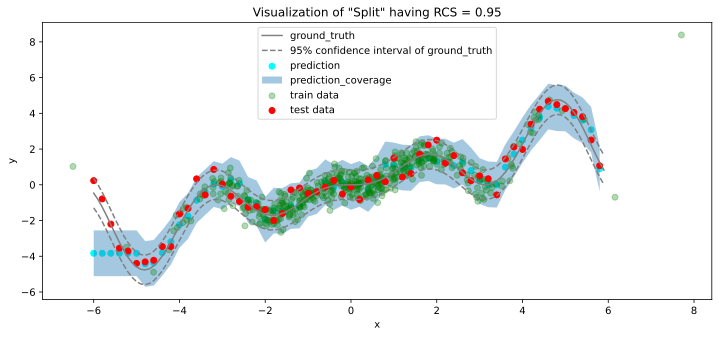

In [8]:
plot_data(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    y_pred=y_pred_split,
    y_pred_interval=y_interval_split,
    method="Split"
)

<div align="justify">


We see that the Split method coverages almost everything except for the three far left test points. It should be pointed out that the intervals created through the Split method with the defined non-conformity function always predicts intervals with equal width. While already having satisfactory *RCS* the methods is heavily dependent on the split size.

</div>

### Barebone Split Implementation

In [9]:
# Define the non-conformity function
def absolute_residual_score(model,X,y):
    return np.abs(y - model.predict(X))

# 2.Step: construct the sequence of residuals
split_non_conformity_scores = absolute_residual_score(model=base_model,X=X_val,y=y_val)

# 3.Step: calculate the quantile
def calculate_quantile(scores, epsilon, method="higher", axis=0):
    if len(scores.shape) == 1:
        n, = scores.shape
    else:
        _,n = scores.shape
    return np.quantile(
        scores,
        axis=axis,
        q=((n + 1) * (1 - epsilon)) / n,
        method=method,
)
split_quantile = calculate_quantile(split_non_conformity_scores,epsilon)

# 4.Step: Construct prediction intervals
def get_prediction_interval_through_quantile(predictions, quantile):
    
    prediction_lower = (predictions - quantile).reshape(-1,1)
    prediction_higher = (predictions + quantile).reshape(-1,1)

    prediction_interval = np.concatenate((prediction_lower,prediction_higher),axis=1)
    return predictions, prediction_interval



split_prediction, split_interval = get_prediction_interval_through_quantile(
    predictions=base_model.predict(X_test), 
    quantile=split_quantile
)

(content:jackknife)=
## Jackknife Method

<div align="justify">

Instead of only using one calibration split to compute $l$ non-conformity scores as in the [Split Method](content:split), the Jackknife (or Leave-one-out) methods computes a $\alpha_i$ for each training point $i = 1, \dots, n$.
It consists of the following four steps:
1. For each training instance $i = 1, \dots, n$ fit a model $\hat{h}_{-i}$ on all data points excluding i.
2. Given $\hat{h}_{-i}$ the non-conformity scores are computed: $\alpha_i^{jack} = f_{\hat{h}_{-i}}(y_i,x_i)$ for each $i =1, \dots, n$.
3. Based on these scores $\alpha_1^{jack}, \dots, \alpha_{n}^{jack}$ the corresponding quantile $q_{jack} =\lceil (1-\epsilon)*(n+1)\rceil \text{-quantile of the sequence }(\alpha_{1}^{jack},\alpha_{2}^{jack} \dots , \alpha_{n}^{jack})$ is calculated.
4. The prediction interval for a new instance $x_{n+1}$ is calculated through $\pm \ q_{jack}$:

$$

    [\hat{h}(x_{n+1}) - q_{jack} , \hat{h}(x_{n+1}) + q_{jack}],

$$

where $\hat{h}$ is the model trained on all $n$ data points.

To now change from split to Jackknife we only must change `cv = -1` in MAPIE, thus indicating we want to train models $\hat{h}_{-i}$ for all $i = 1, \dots, n$
</div>

In [10]:
jackknife_model = MapieRegressor(
    estimator=base_model,
    method="base",
    cv=-1,
    random_state=random_state,
    n_jobs = -1
)
jackknife_model.fit(X_train, y_train)

y_pred_jackknife, y_interval_jackknife = jackknife_model.predict(X_test, alpha=epsilon)
y_interval_jackknife = y_interval_jackknife.reshape(-1, 2)

evaluate_interval(y_test,y_interval_jackknife)

RCS:  0.9666666666666667
RMWS:  2.415146303777198


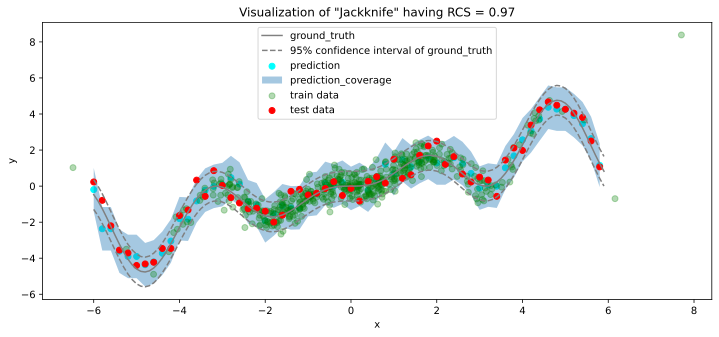

In [11]:
plot_data(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    y_pred=y_pred_jackknife,
    y_pred_interval=y_interval_jackknife,
    method="Jackknife"
)

<div align="justify">

Now having $n$ non-conformity scores results in having a higher RCS. Again the Jackknife method predicts intervals of equal width but are slightly smaller especially in areas with a lot of training points,i.e. region $x \in [-1,1]$.

</div>

```{warning}
In most common cases the coverage of the jackknife method is equal to $1-\epsilon$.
But in scenarios where a regression model is less stable (samples size equal to number of features) the coverage might be less than $1-\epsilon$. We refer to for further details {cite:t}`Barber2019PredictiveIW`.

```

### Barebone Jackknife Implementation

In [12]:
model_missing_data = []
jackknife_non_conformity_scores = [0] * len(X_train)

# 1.Step: Fit the \hat h_{-i} models on the training data
for i in range(len(X_train)):
    new_model = clone(base_model)
    
    X_train_missing_i, y_train_missing_i = np.delete(X_train, i, axis=0), np.delete(
        y_train, i, axis=0
    )
    new_model.fit(X_train_missing_i, y_train_missing_i)
    # 2.Step: calculate non-conformity scores
    jackknife_non_conformity_scores[i] = np.abs(y_train[i] - new_model.predict(
        X_train[i].reshape(1, -1)
    ))
    model_missing_data.append(new_model)

jackknife_non_conformity_scores = np.array(jackknife_non_conformity_scores).ravel()


# 3.Step: Compute quantile
jackknife_quantile = calculate_quantile(jackknife_non_conformity_scores, epsilon)


# 4.Step: Get prediction intervals
jackknife_model = clone(base_model)  # done such that upper cells do not interfere here
jackknife_model.fit(X_train, y_train)

jackknife_prediction, jackknife_interval = get_prediction_interval_through_quantile(
    jackknife_model.predict(X_test), jackknife_quantile
)

(content:jackknife_plus)=
## Jackknife+ Method

<div align="justify">


In Jackknife we build the intervals based on $\hat{h}(x_{N+1})$ and the non-conformity scores $\alpha_i^{jack}$.
As seen in our example it perform better than just using one split, but no theoretical guarantee on the coverage can be given (see {cite:p}`Barber2019PredictiveIW`).
We now their proposed the Jackknife+ method. \
The prediction of $x_{n+1}$ is not only based on $\hat h$ but rather on multiple predictions $\hat{h}_{-1}, \dots , \hat{h}_{-n}$, incorporating the variability of the underlying machine learning algorithm.
Jackknife+ guarantees a coverage of at least $1-2\epsilon$ while not having any assumption other than exchangeablility [^exchangeability].
We again distinguish the steps:
1. For each training instance $i = 1, \dots, n$ fit a model $\hat{h}_{-i}$ on all data points excluding i.
2. Given $i =1, \dots, n$ models $\hat{h}_{-i}$ the non-conformity scores are computed as $\alpha_i^{jack} = f_{\hat{h}_{-i}}(y_i,x_i)$ identically as in [Jackknife](content:jackknife).
3. The prediction interval for a new instance $x_{n+1}$ is calculated through :

$$
    \left[q_{n,\epsilon}^{-}\left(\hat{h}_{-i}(x_{n+1}) - \alpha_i^{jack} \right), \ q_{n,\epsilon}^{+}\left(\hat{h}_{-i}(x_{n+1}) + \alpha_i^{jack} \right) \right]
$$

where

$$
    q_{m,\epsilon}^{+}(v_i) = \lceil (1-\epsilon)*(m+1)\rceil \text{-Quantile of the sequence }(v_1, v_2, \ldots , v_m)
$$

$$
    q_{m,\epsilon}^{-}(v_i) = \lfloor \epsilon*(m+1)\rfloor \text{-Quantile of the sequence }(v_1, v_2, \ldots , v_m) = -q_{n,\epsilon}^{+}(-v_i).
$$

To change from Jackknife to Jackknife+ we must adjust the `method = "plus"`. 


[^exchangeability]: A small example for exchangeability can be found here: {doc}`../chapter-auxilary/exchangeability-excursus`
</div>

In [13]:
jackknife_plus_model = MapieRegressor(
    estimator=base_model,
    method="plus",
    cv=-1,
    random_state=random_state,
    n_jobs=-1
)
jackknife_plus_model.fit(X_train, y_train)

y_pred_jackknife_plus, y_interval_jackknife_plus = jackknife_plus_model.predict(X_test, alpha=epsilon)
y_interval_jackknife_plus = y_interval_jackknife_plus.reshape(-1, 2)

evaluate_interval(y_test,y_interval_jackknife_plus)

RCS:  0.9666666666666667
RMWS:  2.435070750699638


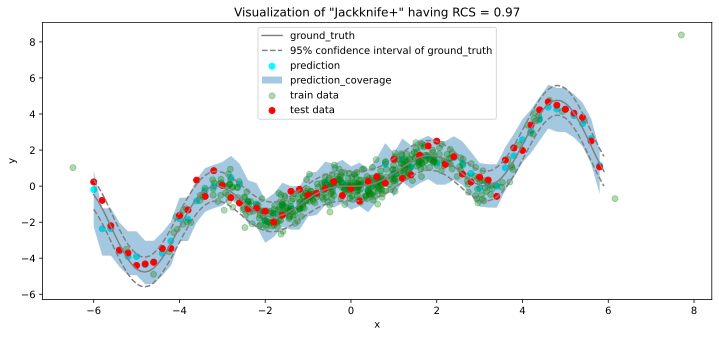

In [14]:
plot_data(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    y_pred=y_pred_jackknife_plus,
    y_pred_interval=y_interval_jackknife_plus,
    method="Jackknife+"
)

<div align="justify">

Comparing both Jackknife+ and Jackknife the coverage has not changed, which can often happen as both empirically often show similar performance {cite:p}`Barber2019PredictiveIW`. The main difference is how the intervals are constructed. 
Whereas Jackknife construct intervals around the model $\hat{h} \pm \alpha_i^{jack}$ trained on all data points, Jackknife+ constructs a interval around the individual $\hat{h}_{-i} \pm \alpha_i^{jack}$. Therefore as can bee seen in the section on [Uncertainty Quantificaion](content:uncertainty_quant), Jackknife+ gives each point a individual interval width whereas in Jackknife each point gets identical interval widths.

</div>

### Barebone Jackknife+ Implementation

In [15]:
# 1.Step: see above in chapter Jackknife
model_missing_data

# 2.Step: see above in chapter Jackknife
jackknife_non_conformity_scores

# 3.Step: get all predictions of the models \hat h_{-i}
missing_model_test_predictions = np.array([
    h_missing_i.predict(X_test) for h_missing_i in model_missing_data
]).T

# 4.Step: build interval
def get_prediction_interval_through_scores(predictions, non_conformity_scores):
    if len(predictions.shape) == 1:
        # the prior methods can also use this Quantile method in this case
        plus_sequence = predictions[:, None] + non_conformity_scores[None, :]
        neg_sequence = predictions[:, None] - non_conformity_scores[None, :]
    else:
        # jackknife plus method
        plus_sequence = predictions + non_conformity_scores
        neg_sequence = predictions - non_conformity_scores
        predictions = np.mean(predictions, axis=-1)

    prediction_higher = calculate_quantile(
        plus_sequence, epsilon, "higher", axis=1
    ).reshape(
        -1, 1
    )  # 1-epsilon Quantile
    prediction_lower = calculate_quantile(
        neg_sequence, 1 - epsilon, "lower", axis=1
    ).reshape(
        -1, 1
    )  # epsilon Quantile

    prediction_interval = np.concatenate((prediction_lower, prediction_higher), axis=1)
    return predictions, prediction_interval

jackknife_plus_prediction, jackknife_plus_interval = (
    get_prediction_interval_through_scores(
        missing_model_test_predictions, jackknife_non_conformity_scores
    )
)

(content:cv_plus)=
## CV+ Method

<div align="justify">

While Jackknife and Jackknife+ improve the coverage of prediction sets, for increasing data points in gets very costly. Training a new model $\hat{h}_{-i}$ for each data point gets impractically for practical application. 
If we think of the amount of $\hat{h}_{-i}$ as a controllable parameter we arrive at the *K-fold CV+* method {cite:p}`Barber2019PredictiveIW`, which we will call CV+ for simplicity.
It can again be expressed in distinct steps, only differing from Jackknife+ in the amount of $\hat{h}_{-i}$ models.
1. Split the training data $x_1, \dots, x_{n}$ into $m$ disjoint partitions $S_1, \dots, S_m$.
2. For each $j = 1, \dots, m$ train a model $\hat{h}_{-S_j}$ on all subsets excluding $S_j$ denoted by $-S_j$ .
3. Given $i =1, \dots, n$ training data points the non-conformity scores are computed: $\alpha_i^{cv+} = y_i - \hat{h}_{-S_i}$ where $S_i$ is the subset containing the data point $x_i$.
4. The prediction interval $Y_\epsilon$ for a new instance $x_{n+1}$ is then constructed through:
   
$$
    \left[q_{n,\epsilon}^{-}\left(\hat{h}_{-S^i}(x_{N+1}) - \alpha_i \right), \ q_{n,\epsilon}^{+}\left(\hat{h}_{-S^i}(x_{N+1}) + \alpha_i \right) \right]
$$

In the following we will use ten folds for CV+, configured by `cv = 10` in [MAPIE](https://mapie.readthedocs.io/en/stable/).
</div>


In [16]:
cv_plus_model = MapieRegressor(
    estimator=base_model,
    method="plus",
    cv=10,
    random_state=random_state,
    n_jobs=-1
)
cv_plus_model.fit(X_train, y_train)

y_pred_cv_plus, y_interval_cv_plus = cv_plus_model.predict(X_test, alpha=epsilon)
y_interval_cv_plus = y_interval_cv_plus.reshape(-1, 2)

evaluate_interval(y_test,y_interval_cv_plus)

RCS:  1.0
RMWS:  2.6608514338015476


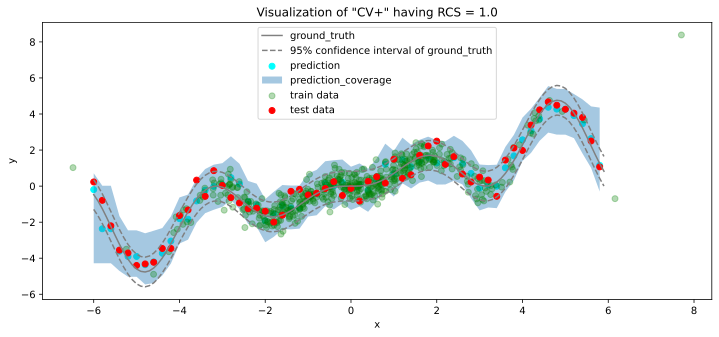

In [17]:
plot_data(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    y_pred=y_pred_cv_plus,
    y_pred_interval=y_interval_cv_plus,
    method="CV+"
)

We now achieve a coverage of 100 percent, as we predict very large intervals for the far left test points.

```{note}
A general advice when to use which method is provided by MAPIE [here](https://mapie.readthedocs.io/en/latest/theoretical_description_regression.html), alongside some more methods for heteroscedastic data or time series.
```

### Barebone CV+ Implementation

In [18]:
#1.Step: Have splitter for the data
amount_of_cv = 10
splitter = KFold(amount_of_cv,shuffle=True,random_state=random_state)

model_missing_data_cv = []
cv_non_conformity_scores = np.zeros(shape=len(X_train))

model_to_non_conformity_scores = {}

# We construct a matrix with many duplicate values containing the predictions of the models h_{-S^i}
# This is needed as one model is related to many non-conformity scores, thus to simply do <prediction> - <non_conformity_score> we need duplicates in <prediction>
prediction_matrix = np.zeros(shape=(len(X_test),len(X_train)))

# 2.Step: Fit the \hat h_{-S^i} models on the training data
for train_ind,test_ind in splitter.split(X_train,y_train):
    X_train_current,X_test_current,y_train_current,y_test_current = X_train[train_ind],X_train[test_ind],y_train[train_ind],y_train[test_ind]
    
    new_model = clone(base_model)
    
    new_model.fit(X_train_current, y_train_current)
    
    # 3.Step: calculate non-conformity scores
    cv_non_conformity_scores[test_ind] = absolute_residual_score(new_model,X_test_current, y_test_current)

    
    
    model_missing_data_cv.append(new_model)
    
    
    # Gather the predictions of the models
    prediction_matrix[:,test_ind] = new_model.predict(X_test)[:,None]
    
# 4.Step: Construct the prediction intervals
jackknife_plus_cv_prediction, jackknife_plus_cv_interval = (
    get_prediction_interval_through_scores(
        prediction_matrix, cv_non_conformity_scores
    )
)

(content:uncertainty_quant)=
## Uncertainty Quantification in Conformal Regression
<div align="justify">

Quantifying the uncertainty of conformal regression outputs can intuitively be done by looking at the interval widths.
- The split method gives all intervals the same width, making it not very useful for individual uncertainty quantification.
- Similiarly Jackknife gives each point the same width, whilst much smaller.
- Incorporating the randomness of the regression model, Jackknife+ assigns each point a individual interval width. Thus making it more useful determining the uncertainty of the model for each point.
- Finally CV+ having fewer underlying $\hat h$ gives us also individual intervals. These are often much bigger than those of Jackknife+, but using Jackknife+ on large data sets with complex models can become intractable. Again we get insight in the uncertainty for each individual point due to the individual interval widths.

</div>

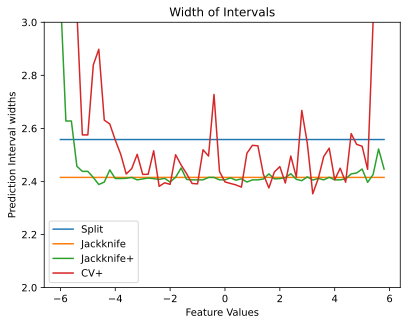

In [19]:
fig,ax = plt.subplots()

methods = ["Split","Jackknife","Jackknife+","CV+"]
intervals = [y_interval_split, y_interval_jackknife, y_interval_jackknife_plus, y_interval_cv_plus]
methods_to_intervals = dict(zip(methods,intervals))

ax.set_ylim([2,3])
for method in methods:
    ax.plot(X_test, methods_to_intervals[method][:,1] - methods_to_intervals[method][:,0], label=method)

ax.set_xlabel("Feature Values")
ax.set_ylabel("Prediction Interval widths")
ax.set_title("Width of Intervals")
ax.legend()
plt.show()

